### Курсовой проект

##### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

##### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

##### Метрика качества

F1-score (sklearn.metrics.f1_score)

F1 > 0.5

In [2]:
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()


### Обзор данных

##### Описание базового датасета

    
    Home Ownership - домовладение
    Annual Income - годовой доход
    Years in current job - количество лет на текущем месте работы
    Tax Liens - налоговые обременения
    Number of Open Accounts - количество открытых счетов
    Years of Credit History - количество лет кредитной истории
    Maximum Open Credit - наибольший открытый кредит
    Number of Credit Problems - количество проблем с кредитом
    Months since last delinquent - количество месяцев с последней просрочки платежа
    Bankruptcies - банкротства
    Purpose - цель кредита
    Term - срок кредита
    Current Loan Amount - текущая сумма кредита
    Current Credit Balance - текущий кредитный баланс
    Monthly Debt - ежемесячный долг
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


##### Пути к директориям и файлам

In [8]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

##### Загрузка данных

Тренировочный датасет:

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
train_df.shape

(7500, 17)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##### Обзор количественных признаков

In [12]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


##### Обзор категориальных признаков

In [13]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

##### Обзор целевой переменной

In [14]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обработка выбросов

##### Распределение фичей

In [15]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.drop(['Credit Default'], axis=1, inplace=True)
train_df_num_features.head(5).T

,0,1,2,3,4
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0
Current Loan Amount,99999999.0,264968.0,99999999.0,121396.0,125840.0
Current Credit Balance,47386.0,394972.0,308389.0,95855.0,93309.0


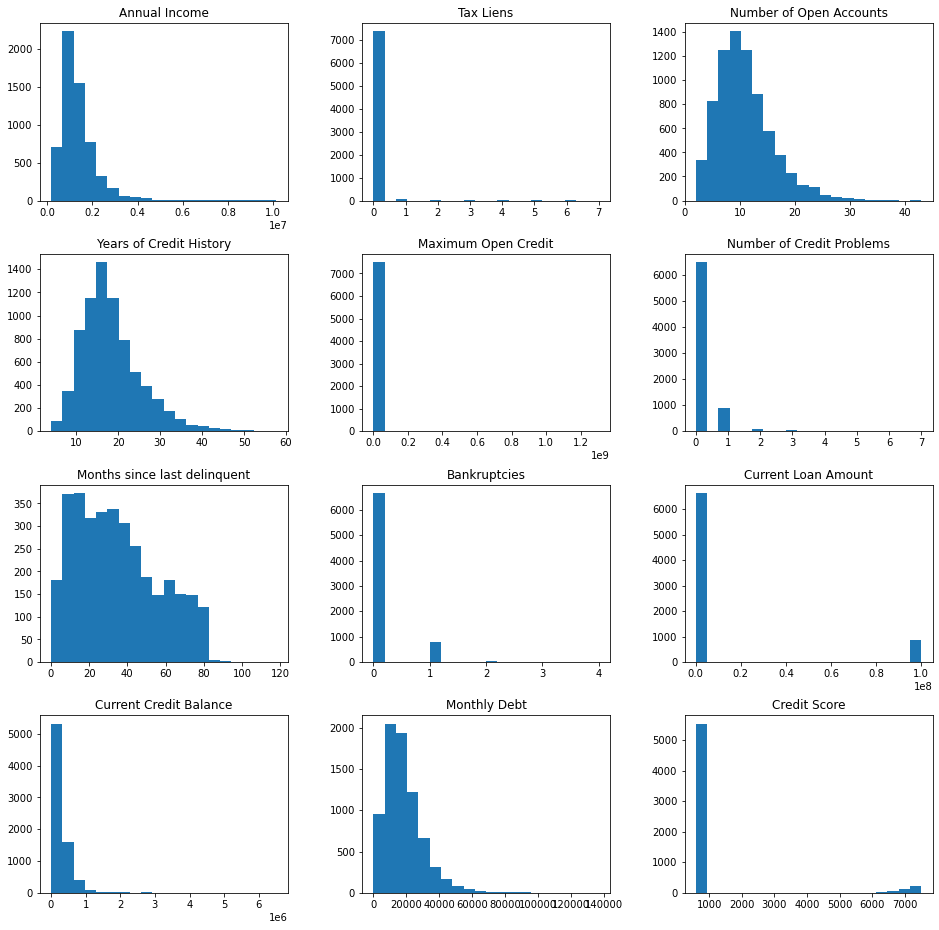

In [16]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Для некоторых признаков наблюдаются аномалии, взглянем поближе:

##### Number of Open Accounts


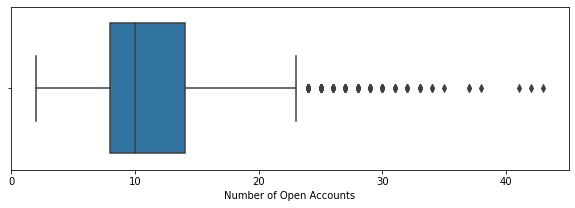

In [17]:
plt.figure(figsize=(10, 3))

sns.boxplot(train_df['Number of Open Accounts'])

plt.xlabel('Number of Open Accounts')
plt.show()

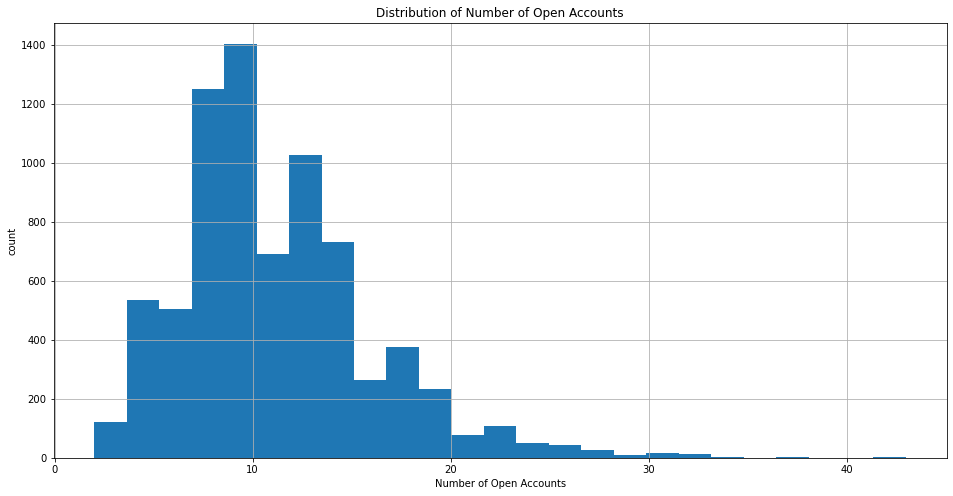

In [18]:
plt.figure(figsize = (16, 8))

train_df['Number of Open Accounts'].hist(bins=25)
plt.ylabel('count')
plt.xlabel('Number of Open Accounts')

plt.title('Distribution of Number of Open Accounts')
plt.show()

Виден небольшой выброс, заменяем все значения больше 23 медианой

In [19]:
train_df['Number of Open Accounts'].median()

10.0

In [20]:
train_df.loc[train_df['Number of Open Accounts'] > 23, 'Number of Open Accounts'] = train_df['Number of Open Accounts'].median()

##### Years of Credit History

In [21]:
train_df['Years of Credit History'].value_counts().sort_index().tail(10)

49.1    1
50.0    1
50.6    1
50.9    1
51.0    1
51.3    1
51.5    1
51.9    1
52.2    1
57.7    1
Name: Years of Credit History, dtype: int64

Замена значений больше 40 на 40

In [22]:
train_df.loc[train_df['Years of Credit History'] > 40, 'Years of Credit History'] = train_df['Years of Credit History'].median()

##### Annual Income

In [23]:
train_df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

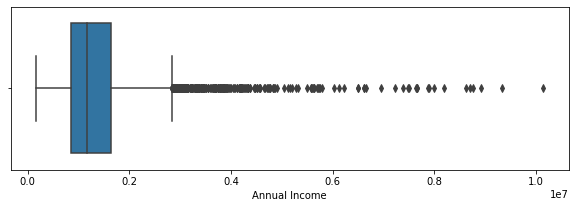

In [24]:
plt.figure(figsize=(10, 3))

sns.boxplot(train_df['Annual Income'])

plt.xlabel('Annual Income')
plt.show()

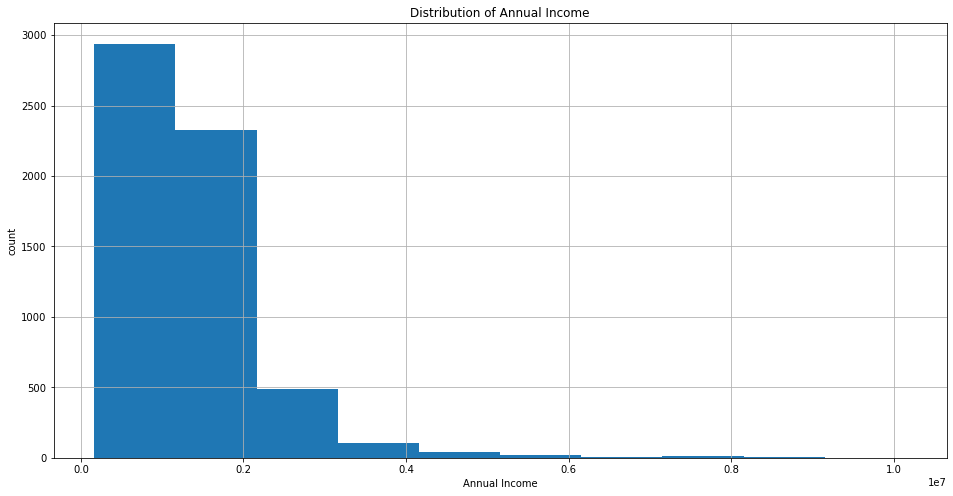

In [25]:
plt.figure(figsize = (16, 8))

train_df['Annual Income'].hist(bins=10)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.title('Distribution of Annual Income')
plt.show()

Виден довольно большой хвост. Т.к. годовой доход - финансовый показатель, ожидается логнормальное распределение, поэтому заменяем все, что за .97 квантилем - .97 квантилем

In [26]:
train_df.loc[train_df['Annual Income'] > train_df['Annual Income'].quantile(.97), ['Annual Income']] =\
            train_df['Annual Income'].quantile(.97)

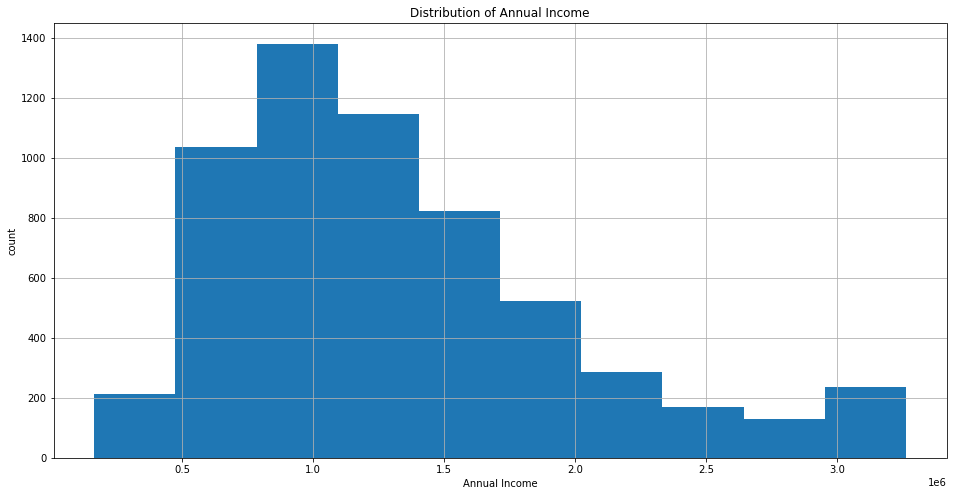

In [27]:
plt.figure(figsize = (16, 8))

train_df['Annual Income'].hist(bins=10)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.title('Distribution of Annual Income')
plt.show()

##### Credit Score

In [28]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Кредитный рейтинг в РФ имеет значения от 1 до 999, минимум 585 - говорит о том, что речь идет российском скоринге, т.к. значение в 625+ является примерной границей удовлетворительного кредитного рейтинга (в США от 700 до 790)

In [29]:
len(train_df[train_df['Credit Score'] > 999])

400

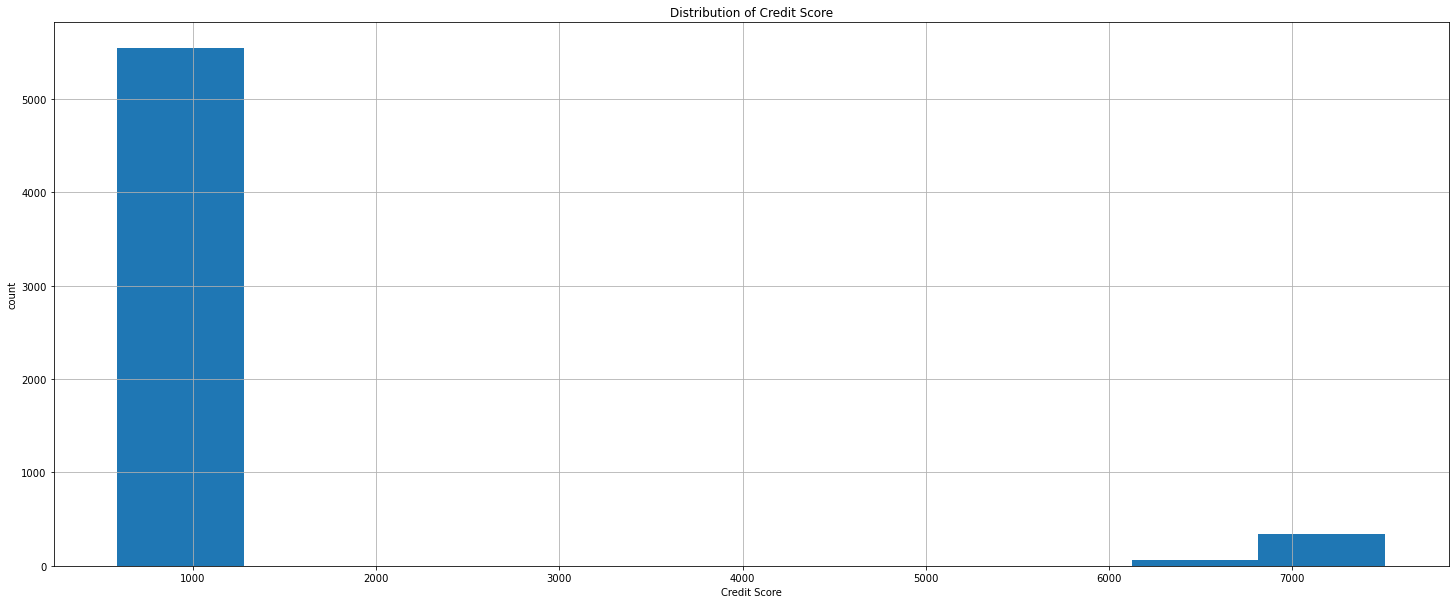

In [30]:
plt.figure(figsize = (25, 10))

train_df['Credit Score'].hist(bins=10)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.title('Distribution of Credit Score')
plt.show()

In [31]:
train_df['Credit Score'].median()

731.0

In [32]:
train_df.loc[(train_df['Credit Score'] > 999) | (train_df['Credit Score'] < 625), 'Credit Score'] = train_df['Credit Score'].median()

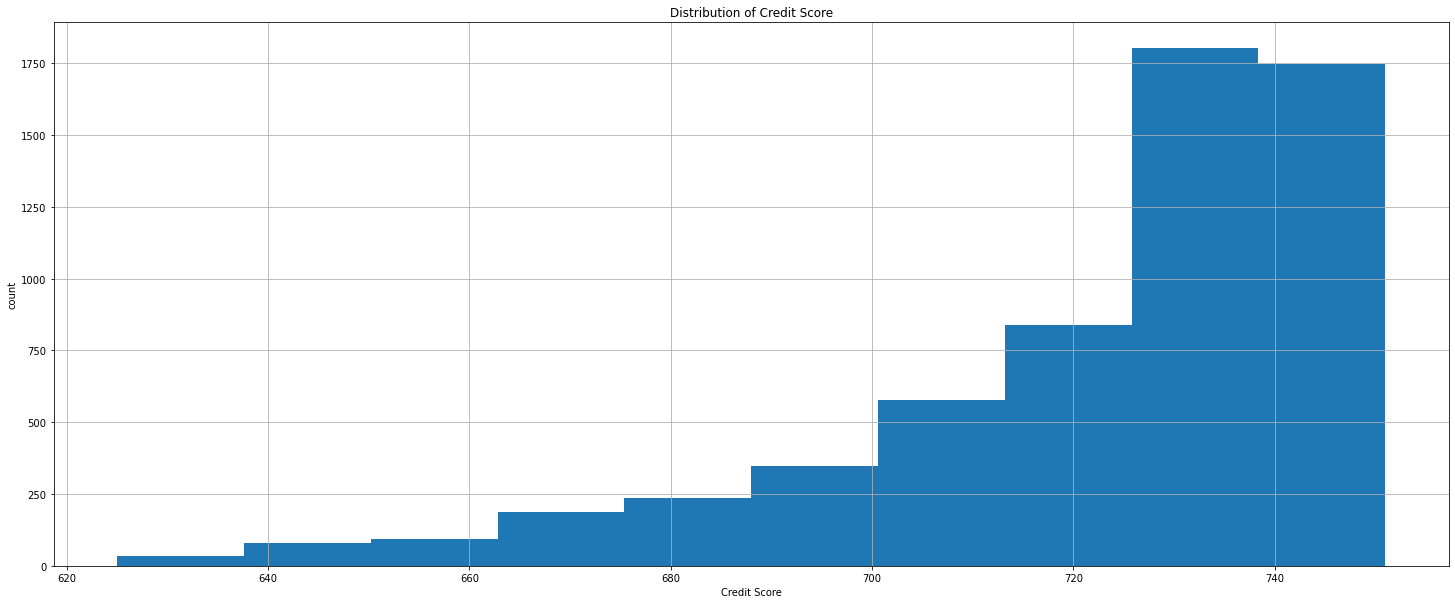

In [33]:
plt.figure(figsize = (25, 10))

train_df['Credit Score'].hist(bins=10)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.title('Distribution of Credit Score')
plt.show()

### Обработка пропусков

In [34]:
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

<AxesSubplot:>

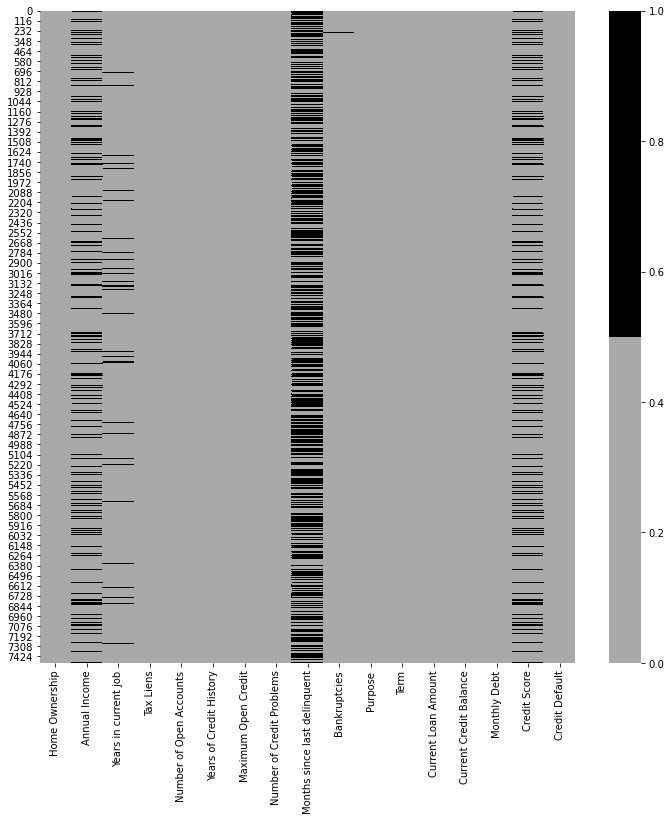

In [35]:
plt.figure(figsize=(12, 12))
colours = ['darkgrey', 'black'] 
sns.heatmap(train_df.isnull(), cmap=sns.color_palette(colours))

Удаляем признак Months since last delinquent, т.к. слишком много пропусков

Остальные пропуски заменяем медианой

In [36]:
train_df = train_df.drop(columns=['Months since last delinquent'])

In [37]:
train_df.loc[train_df['Credit Score'].isnull(), 'Credit Score'] = train_df['Credit Score'].median()

In [38]:
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()

In [39]:
train_df.loc[train_df['Bankruptcies'].isnull(), 'Bankruptcies'] = train_df['Bankruptcies'].median()

In [40]:
len(train_df) - train_df.count()

Home Ownership                 0
Annual Income                  0
Years in current job         371
Tax Liens                      0
Number of Open Accounts        0
Years of Credit History        0
Maximum Open Credit            0
Number of Credit Problems      0
Bankruptcies                   0
Purpose                        0
Term                           0
Current Loan Amount            0
Current Credit Balance         0
Monthly Debt                   0
Credit Score                   0
Credit Default                 0
dtype: int64

### Категориальные признаки

##### Years in Current Job

In [41]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [42]:
len(train_df['Years in current job']) - train_df['Years in current job'].count()

371

Заполняем пропуски модой и преобразуем категориальный признак в количественный

In [43]:
train_df['Years in current job'] = train_df['Years in current job'].fillna('10+ years')

In [44]:
train_df['Years in current job'] = train_df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype('int8')

In [45]:
train_df['Term'] = pd.Series(train_df['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)

##### Dummies

In [46]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'], prefix='Home Ownership')], axis=1)

##### Purpose

In [47]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

<AxesSubplot:title={'center':'Purpose / Credit Default'}, xlabel='Purpose'>

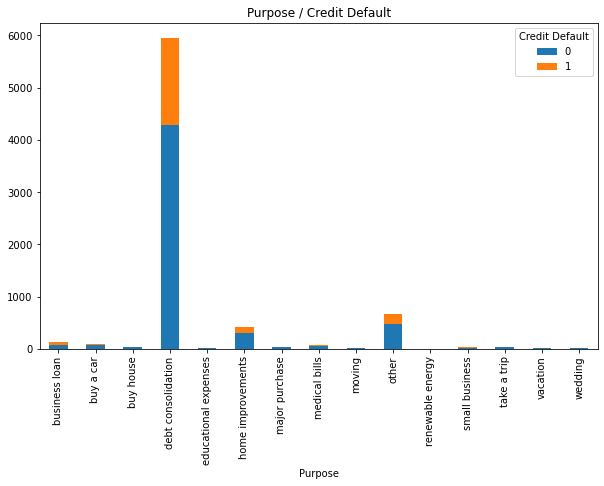

In [48]:
purpose_cr_deafult = train_df[['Purpose','Credit Default']]
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

Разбиваем цель кредита на категории и объединяем по тематике (например, home improvements, moving и renewable energy)

In [49]:
train_df['Purpose'] = train_df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'4',
                                'home improvements':'1',
                                'business loan':'2',
                                'buy a car':'3',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'4',
                                'buy house':'3',
                                'small business':'2',
                                'wedding':'4',
                                'moving':'1',
                                'educational expenses':'3',
                                'vacation':'4',
                                'renewable energy':'1'
                                }).astype(float)

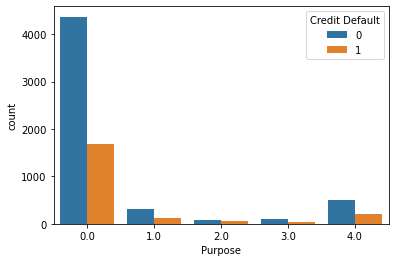

In [50]:
sns.countplot(x="Purpose", hue='Credit Default', data=train_df)
plt.show()

##### Новые признаки

Объединяем Tax Liens, Number of credit problems, Bankrupticies в признак Problem Free - все наблюдения, у которых нули = True, остальные = False

In [51]:
train_df['Problem Free'] = (train_df['Tax Liens'] == 0) & (train_df['Bankruptcies'] == 0) & (train_df['Number of Credit Problems'] == 0)

In [52]:
train_df['Problem Free'].value_counts()

True     6469
False    1031
Name: Problem Free, dtype: int64

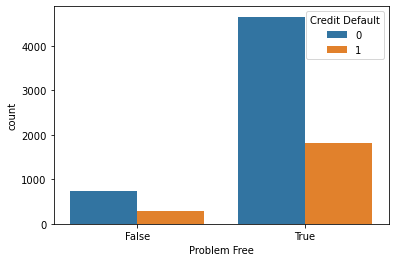

In [53]:
sns.countplot(x="Problem Free", hue='Credit Default', data=train_df)
plt.show()

Разделяем кредитный рейтинг на категории

In [54]:
train_df.loc[(train_df['Credit Score'] < 700), 'Credit Score'] = 0
train_df.loc[(train_df['Credit Score'] >= 700) & (train_df['Credit Score'] < 730), 'Credit Score'] = 1
train_df.loc[(train_df['Credit Score'] >= 730) & (train_df['Credit Score'] < 735), 'Credit Score'] = 2
train_df.loc[(train_df['Credit Score'] >= 735) & (train_df['Credit Score'] < 750), 'Credit Score'] = 3
train_df.loc[(train_df['Credit Score'] >= 750), 'Credit Score'] = 4

In [55]:
train_df['Credit Score'].value_counts().sort_index()

0.0     947
1.0    1785
2.0    2541
3.0    2073
4.0     154
Name: Credit Score, dtype: int64

In [56]:
# Что получилось в итоге
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int8   
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Purpose                       7500 non-null   float64
 10  Term                          7500 non-null   int8   
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [57]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
    
    def fit(self, X):
        # Копирование датафрейма
        X = X.copy()
        
        # Удаление признака Months since last delinquent
        X = X.drop(columns=['Months since last delinquent'])
        
        # Расчет медиан, квантилей
        self.medians = X.median()
        self.annual_quantile = X['Annual Income'].quantile(.97)
        
    def transform(self, X):
        # Number of Open Accounts
        X.loc[X['Number of Open Accounts'] > 23, 'Number of Open Accounts'] = self.medians['Number of Open Accounts']
        
        # Years of Credit History
        X.loc[X['Years of Credit History'] > 40, 'Years of Credit History'] = 40
        
        # Annual Income
        X.loc[X['Annual Income'] > self.annual_quantile, ['Annual Income']] = self.annual_quantile
        
        # Credit Score
        X.loc[(X['Credit Score'] > 999) | (X['Credit Score'] < 625), 'Credit Score'] = self.medians['Credit Score']
        X.loc[X['Credit Score'].isnull(), 'Credit Score'] = self.medians['Credit Score']
        
        X.loc[(X['Credit Score'] < 700), 'Credit Score'] = 0
        X.loc[(X['Credit Score'] >= 700) & (X['Credit Score'] < 730), 'Credit Score'] = 1
        X.loc[(X['Credit Score'] >= 730) & (X['Credit Score'] < 735), 'Credit Score'] = 2
        X.loc[(X['Credit Score'] >= 735) & (X['Credit Score'] < 750), 'Credit Score'] = 3
        X.loc[(X['Credit Score'] >= 750), 'Credit Score'] = 4
        
        #Annual Income
        X.loc[X['Annual Income'].isnull(), 'Annual Income'] = self.medians['Annual Income']
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isnull(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        # Years in current job
        X['Years in current job'] = X['Years in current job'].fillna('10+ years')
        X['Years in current job'] = X['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)
        
        # Term
        X['Term'] = pd.Series(X['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)
        
        # Dummies. Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Home Ownership')], axis=1)
        
        # Purpose
        X['Purpose'] = X['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'4',
                                'home improvements':'1',
                                'business loan':'2',
                                'buy a car':'3',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'4',
                                'buy house':'3',
                                'small business':'2',
                                'wedding':'4',
                                'moving':'1',
                                'educational expenses':'3',
                                'vacation':'4',
                                'renewable energy':'1'
                                }).astype(float)
        
        # Новый признак Problem Free
        X['Problem Free'] = (X['Tax Liens'] == 0) & (X['Bankruptcies'] == 0) & (X['Number of Credit Problems'] == 0)
        
        return X

##### Отбор признаков

In [58]:
TARGET_NAME = 'Credit Default'

In [59]:
FEATURE_NAMES = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Purpose',
        'Term',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
        'Home Ownership_Have Mortgage',
        'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home',
        'Home Ownership_Rent',
        'Problem Free'
                         ]

### Анализ данных

Матрица корреляций

<AxesSubplot:>

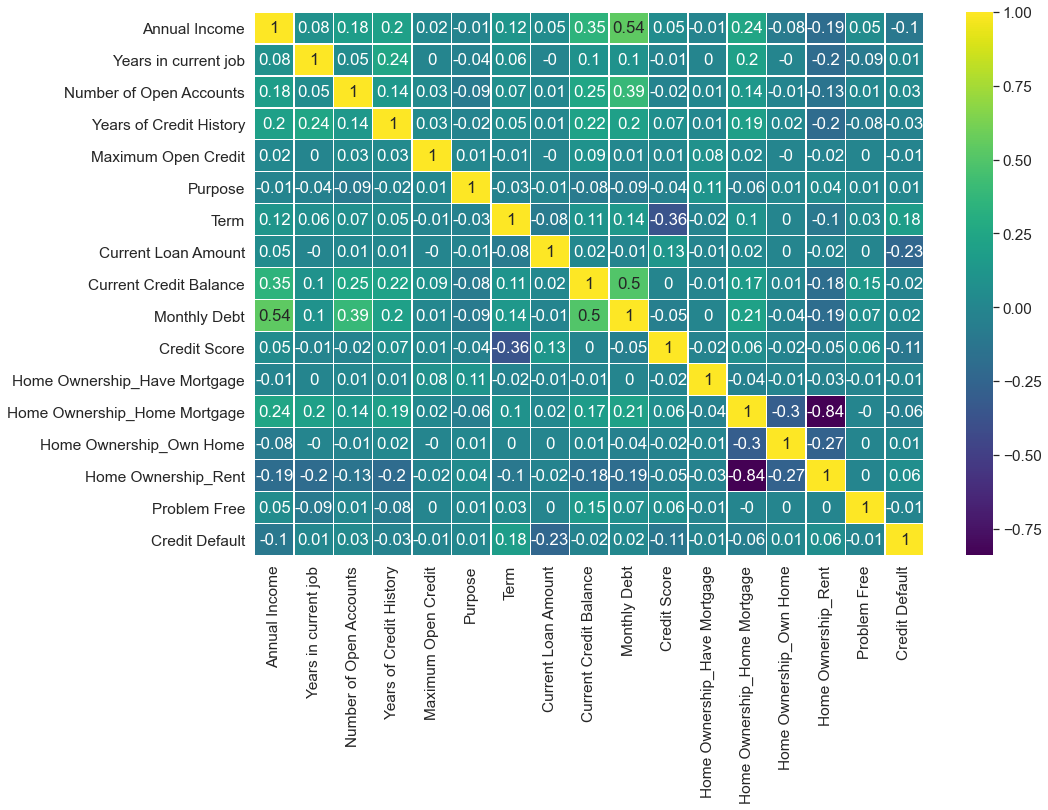

In [60]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df[FEATURE_NAMES + [TARGET_NAME]].corr()
corr_matrix = np.round(corr_matrix, 2)
# corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='viridis')

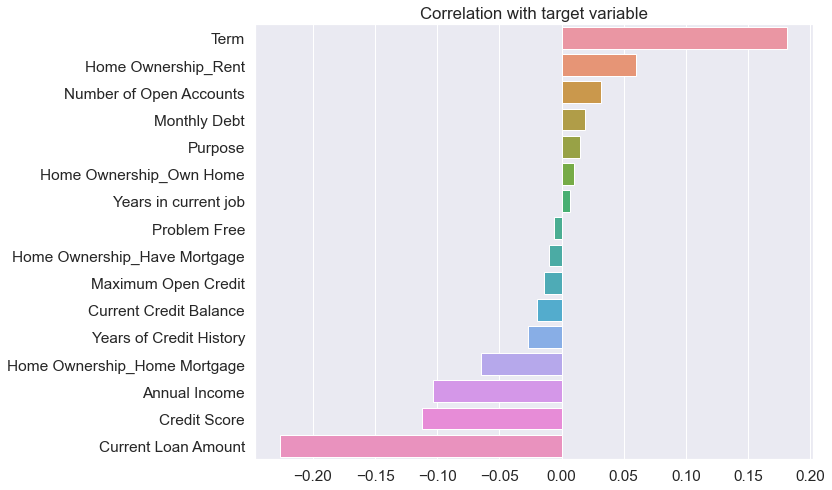

In [61]:
corr_with_target = train_df[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Применение на тестовом датасете

Обзор тестового датасета

In [62]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [63]:
test_df.shape

(2500, 16)

In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### Разбиение на train и test

In [65]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [66]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.shape, test_df.shape

((7500, 22), (2500, 21))

In [67]:
# нормализация

scaler = StandardScaler()
norm_df = train_df.copy()
norm_df[FEATURE_NAMES] = scaler.fit_transform(norm_df[FEATURE_NAMES])
train_df = norm_df.copy()

In [68]:
scaler = StandardScaler()
norm_df = test_df.copy()
norm_df[FEATURE_NAMES] = scaler.fit_transform(norm_df[FEATURE_NAMES])
test_df = norm_df.copy()

In [69]:
X = train_df[FEATURE_NAMES]
y = train_df[TARGET_NAME]
test_df = test_df[FEATURE_NAMES]

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [71]:
X_train.shape, X_valid.shape, test_df.shape

((5025, 16), (2475, 16), (2500, 16))

In [72]:
# балансировка целевой переменной
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3631
1    2788
Name: Credit Default, dtype: int64

In [73]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей

LightGBM 0.50

Kneighbors 0.45

XGBoost 0.47

CatBoost 0.49

GradientBoosting 0.51

In [74]:
model_gbcl = GradientBoostingClassifier(random_state=42)
model_gbcl.fit(X_train, y_train)

y_train_pred = model_gbcl.predict(X_train)
y_test_pred = model_gbcl.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      3631
           1       0.73      0.68      0.70      2788

    accuracy                           0.75      6419
   macro avg       0.75      0.74      0.74      6419
weighted avg       0.75      0.75      0.75      6419

TEST

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1756
           1       0.49      0.54      0.51       719

    accuracy                           0.70      2475
   macro avg       0.64      0.65      0.65      2475
weighted avg       0.71      0.70      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1347  409
1                332  387


Из всех моделей наилучший результат показал градиентный бустинг. Подбираем гиперпараметры и смотрим, улучшат ли они F1

In [75]:
#model_gbcl = GradientBoostingClassifier(random_state=42)

In [76]:
#params = {'n_estimators':[50, 100, 200, 500], 
#          'max_depth':[3, 5, 7, 10],
#          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

IndentationError: unexpected indent (<ipython-input-76-c769fe9854ee>, line 2)

In [ ]:
#cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
#%%time
#
#rs = RandomizedSearchCV(model_gbcl, params, scoring='f1', cv=cv, n_jobs=-1)
#rs.fit(X_train, y_train)

In [ ]:
#rs.best_params_

In [ ]:
#rs.best_score_

In [77]:
model_gbcl = GradientBoostingClassifier(random_state=42,
                                        n_estimators=100,
                                        max_depth=3,
                                        learning_rate=0.05
                                       )
model_gbcl.fit(X_train, y_train)

y_train_pred = model_gbcl.predict(X_train)
y_test_pred = model_gbcl.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      3631
           1       0.70      0.62      0.66      2788

    accuracy                           0.72      6419
   macro avg       0.72      0.71      0.71      6419
weighted avg       0.72      0.72      0.72      6419

TEST

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1756
           1       0.50      0.53      0.52       719

    accuracy                           0.71      2475
   macro avg       0.65      0.66      0.66      2475
weighted avg       0.72      0.71      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1374  382
1                335  384


#### Результат F1-score = 0.52

##### Важность фич

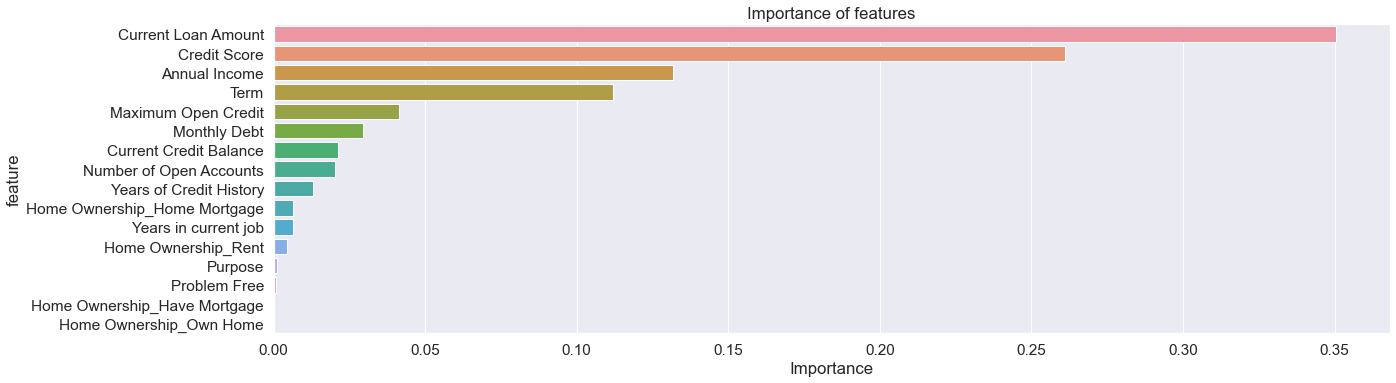

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Term',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years of Credit History',
 'Home Ownership_Home Mortgage',
 'Years in current job',
 'Home Ownership_Rent',
 'Purpose',
 'Problem Free',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Own Home']

In [79]:
show_feature_importances(X_train.columns, model_gbcl.feature_importances_, get_top=16)

#### Прогноз на тестовом датасете

In [80]:
test_df['Credit Default'] = model_gbcl.predict(test_df)

In [83]:
test_df['Id'] = test_df.index.tolist()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Purpose                       2500 non-null   float64
 6   Term                          2500 non-null   float64
 7   Current Loan Amount           2500 non-null   float64
 8   Current Credit Balance        2500 non-null   float64
 9   Monthly Debt                  2500 non-null   float64
 10  Credit Score                  2500 non-null   float64
 11  Home Ownership_Have Mortgage  2500 non-null   float64
 12  Home Ownership_Home Mortgage  2500 non-null   float64
 13  Hom

In [87]:
predictions = test_df[['Id', 'Credit Default']]
predictions.to_csv('NekrasovaLO_predictions.csv', index=False)